In [138]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [139]:
train_data_path = join('/content/train.csv')
test_data_path = join('/content/test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [140]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [141]:
y = train['price']

del train['price']

In [142]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

In [143]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [144]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [145]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [146]:
test['date'] = test['date'].apply(str).apply(lambda i: i[:6]).astype(str)

# del test['id'] # Removed redundant deletion

print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [147]:
y

,price
0,221900.0
1,180000.0
2,510000.0
3,257500.0
4,291850.0
...,...
15030,610685.0
15031,1007500.0
15032,360000.0
15033,400000.0


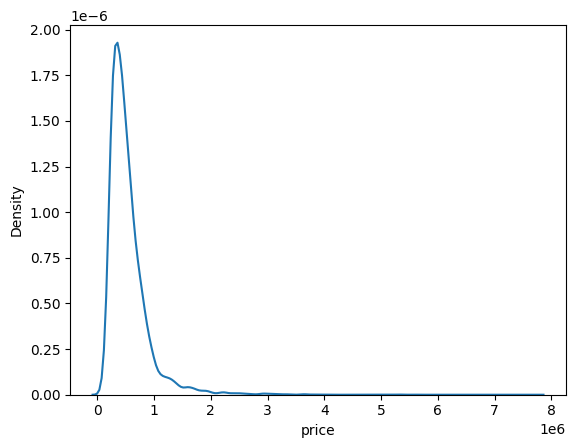

In [148]:
#코드 작성
sns.kdeplot(y)
plt.show()

In [149]:
y = np.log1p(y)
y

,price
0,12.309987
1,12.100718
2,13.142168
3,12.458779
4,12.583999
...,...
15030,13.322338
15031,13.822984
15032,12.793862
15033,12.899222


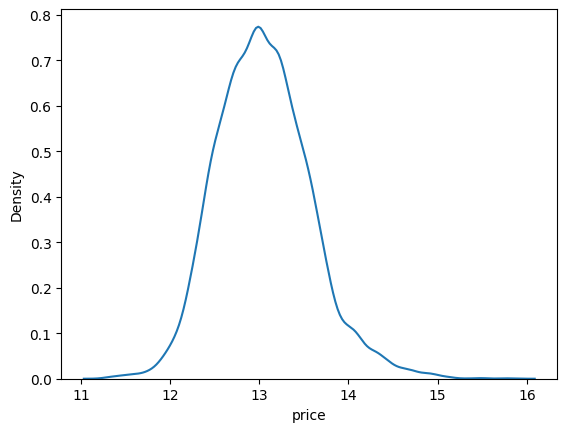

In [150]:
sns.kdeplot(y)
plt.show()

In [151]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 2. 간단한 전처리
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

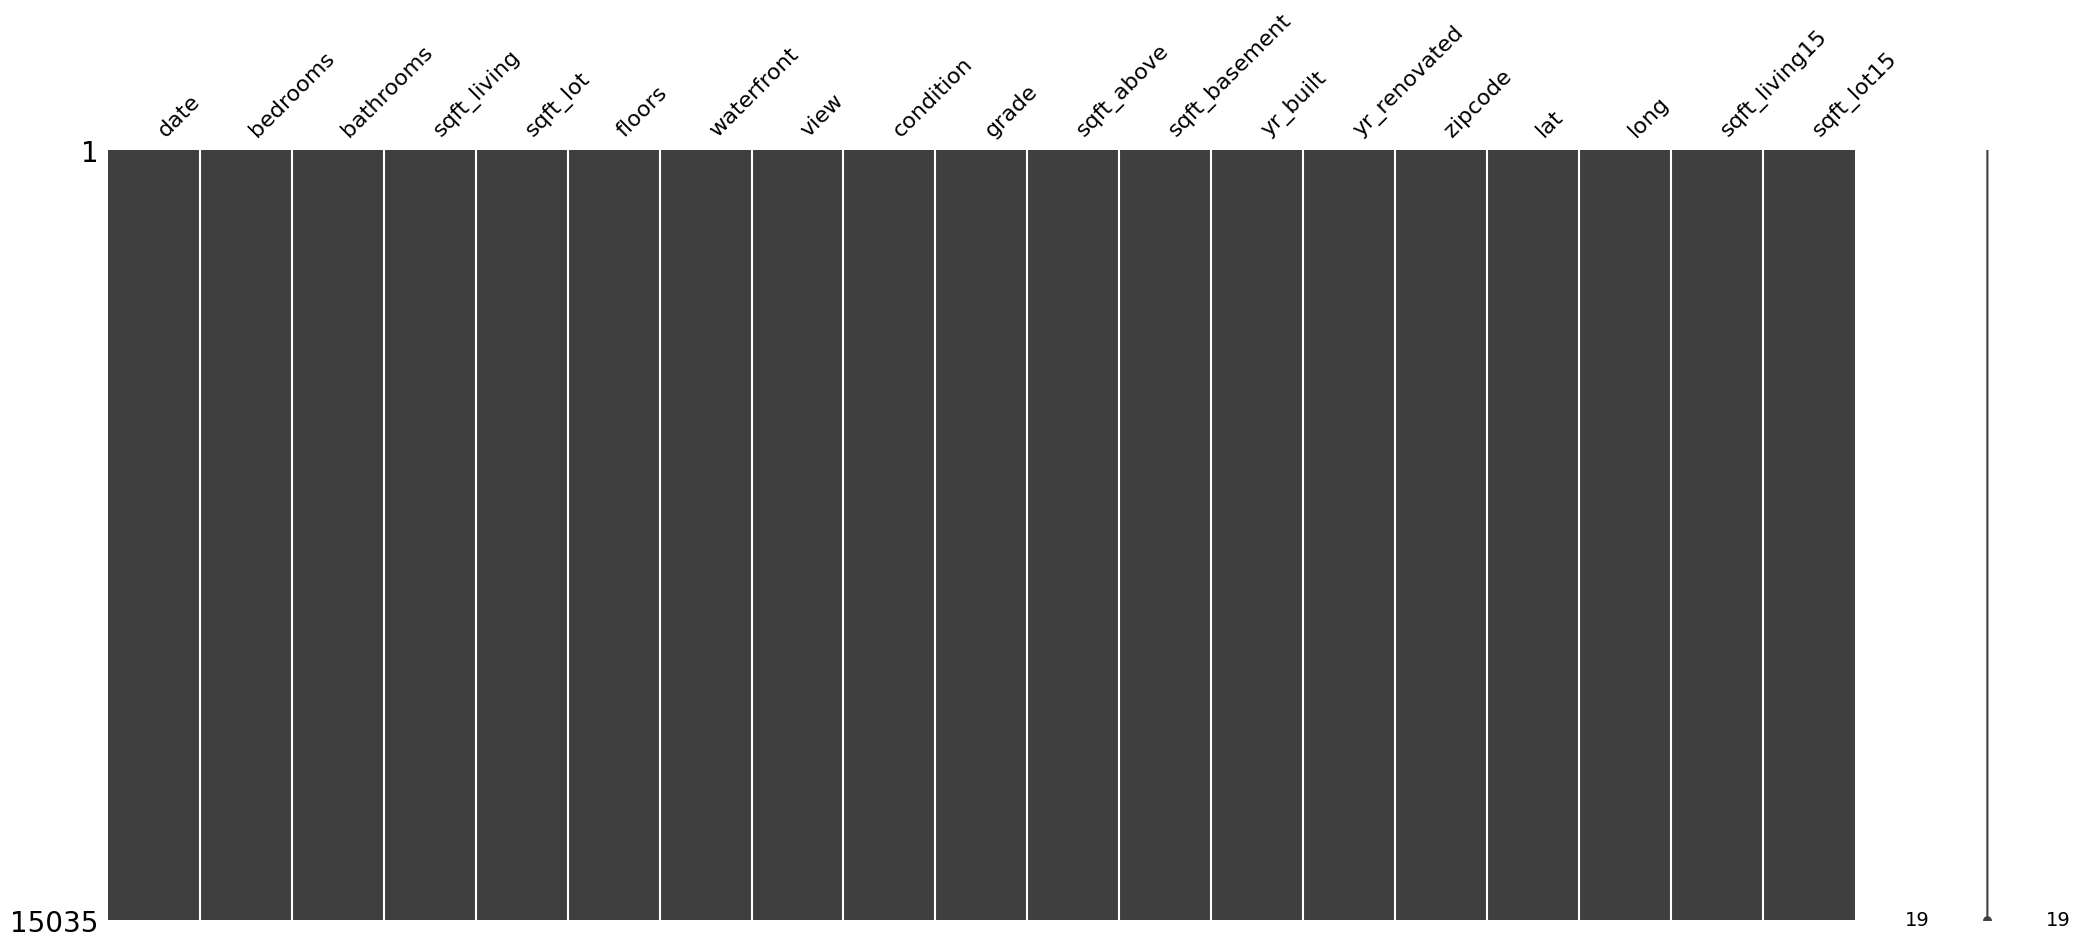

In [152]:
msno.matrix(train)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [153]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

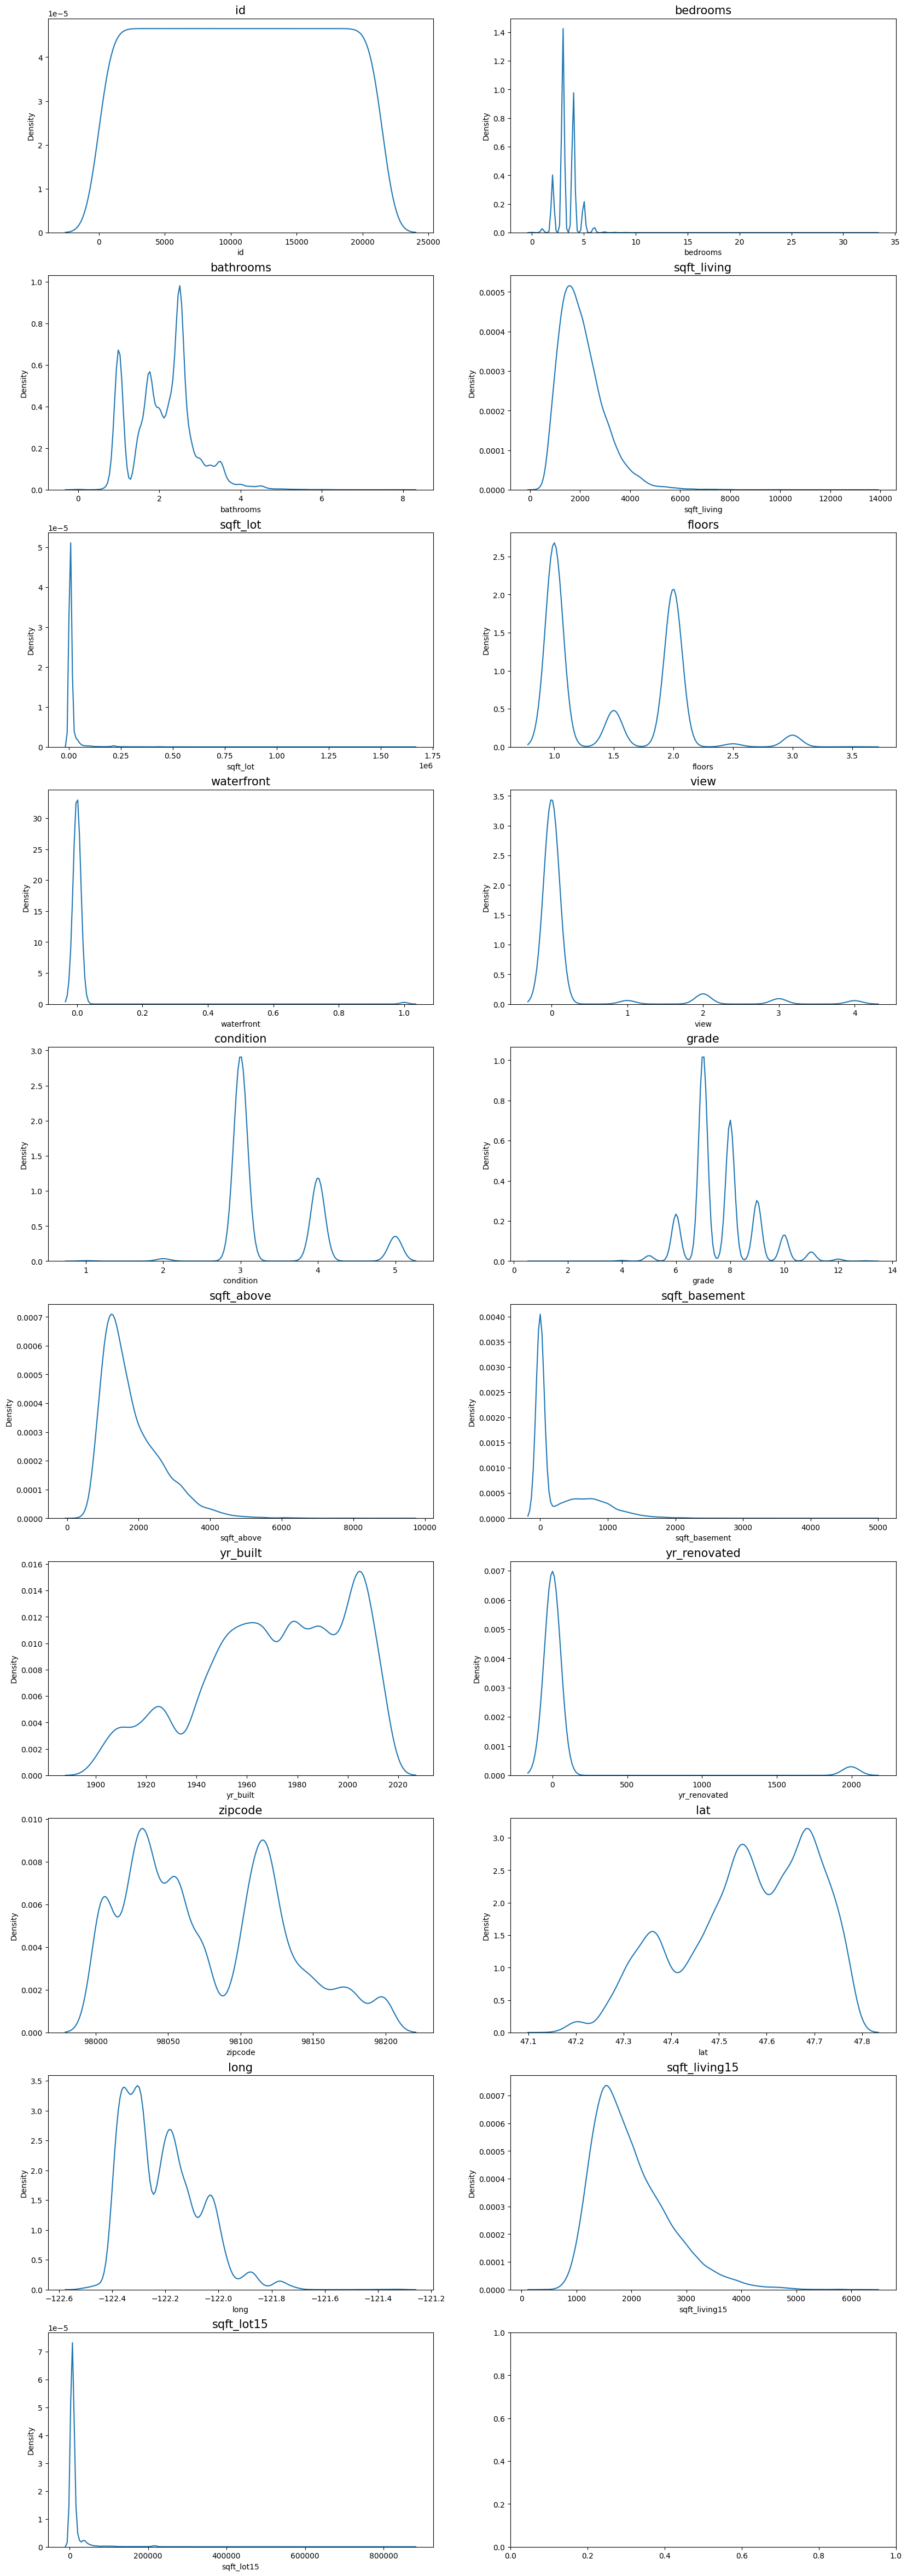

In [154]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수와 date 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns.drop(['date']) # Exclude 'date' and 'id' columns for plotting
for row in range(10):
  for col in range(2):
    if count < len(columns):
      sns.kdeplot(data[columns[count]], ax=ax[row][col])
      ax[row][col].set_title(columns[count], fontsize=15)
      count+=1
    else:
      break
  if count == len(columns):
    break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [155]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

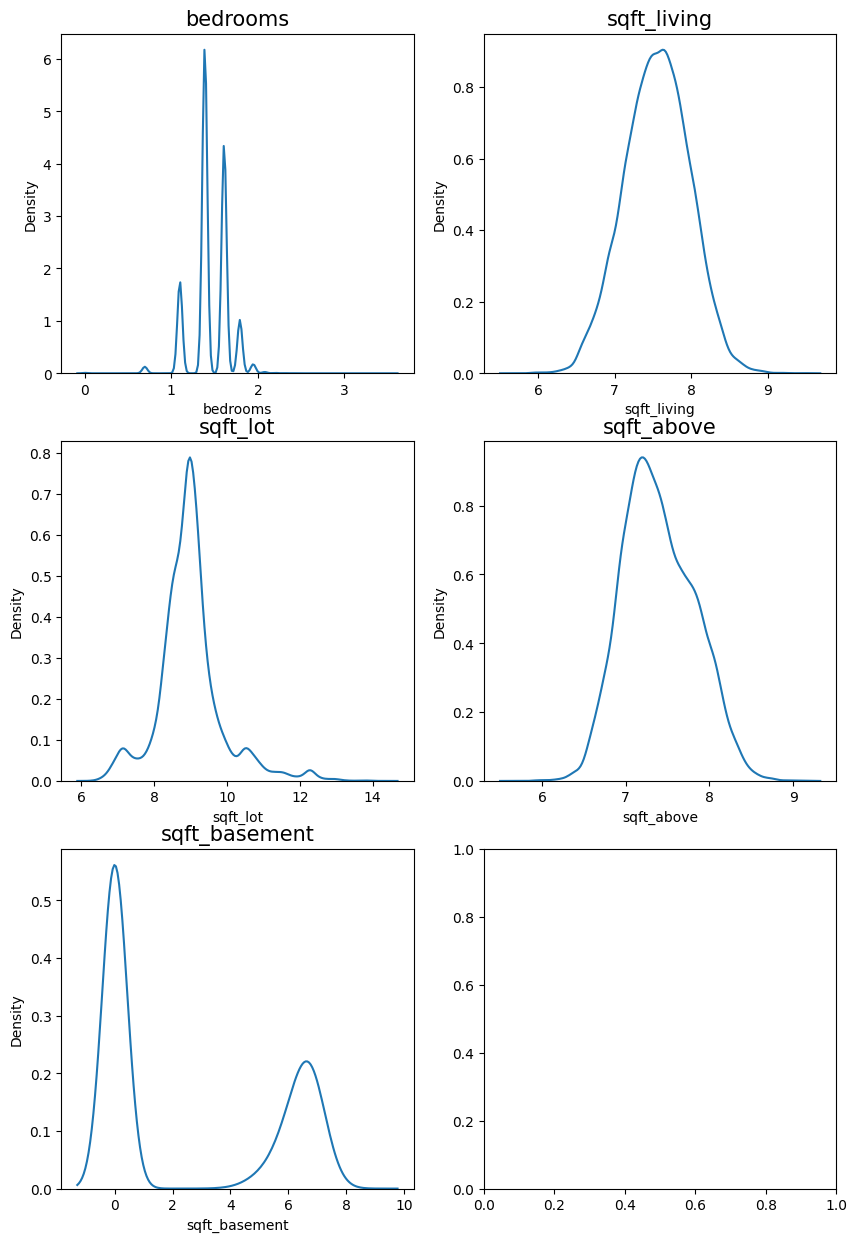

In [156]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [157]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

릿지, 랏쏘도 추가해 5개 모델로 블랜딩

In [158]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

모델을 추가적으로 더 쓰려고 했지만 받아드리는 feature 의 개수가 달라서 취소함

In [159]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# models = [
#     {'name': 'GradientBoosting', 'model': GradientBoostingRegressor(random_state=2019)},
#     {'name': 'XGBoost', 'model': xgb.XGBRegressor(random_state=2019)},
#     {'name': 'LightGBM', 'model': lgb.LGBMRegressor(random_state=2019)},
#     {'name': 'RandomForest', 'model': RandomForestRegressor(random_state=2019)}, # random_state 통일
#     {'name': 'DecisionTree', 'model': DecisionTreeRegressor(random_state=2019)}, # random_state 통일
#     {'name': 'Ridge', 'model': make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=2019))}, # random_state 통일
#     {'name': 'Lasso', 'model': make_pipeline(StandardScaler(), Lasso(alpha=0.1, random_state=2019))} # random_state 통일
# ]

In [174]:
# 2. 모델 정의 (3개로 줄임)
models = [
    {'name': 'GradientBoosting', 'model': GradientBoostingRegressor(random_state=2019)},
    {'name': 'XGBoost', 'model': xgb.XGBRegressor(random_state=2019)},
    {'name': 'LightGBM', 'model': lgb.LGBMRegressor(random_state=2019, force_row_wise=True)} # 메모리 부족 시 force_row_wise=True 사용 고려
]
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [175]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)
    for m in models:
        score = np.mean(cross_val_score(m['model'], x.values, y, cv=kfold))
        print("Model {} CV score : {:.4f}".format(m['name'], score))

In [178]:
# 성능 확인
get_cv_score(models)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py", line 658, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '20141013T000000'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py", line 658, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '20150225T000000'


In [ ]:
# 4. 블렌딩 함수 (Averaging Blending)
def AveragingBlending(models, x_data, y_data, sub_x_data):
    print("\n--- 모델 훈련 시작 ---")
    for m in models:
        # 모델 훈련
        m['model'].fit(x_data.values, y_data)
        print(f"- {m['name']} 훈련 완료")

    print("\n--- 예측 시작 ---")
    predictions = np.column_stack([
        m['model'].predict(sub_x_data.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)

In [ ]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [ ]:
sub.to_csv('submission.csv', index=False)